# Paper CHF - 10 beats

## Setup

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
from imblearn.metrics import classification_report_imbalanced

import time

In [2]:
THREADS_TO_USE = 4

In [3]:
def parse_accuracy_per_class(conf_matrix, classes):
    acc_per_class = dict()
    for i, c in enumerate(classes):
        tn, fp, fn, tp = conf_matrix[i].ravel()
        acc_per_class[c] = (tp + tn) /(tp + tn + fp + fn)
    return acc_per_class

## Load dataset

In [4]:
data = pd.read_csv('../dataset/st_dataset_10beats.csv')
data = data.dropna()
data.head()

,id,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,...,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16,label
0,e0106,39.341333,39.831764,39.826684,11.282887,1.634628,0.913825,-0.771782,-1.359522,-0.634856,...,-0.049375,0.037769,-0.045755,0.051531,-0.078515,0.013704,-0.024545,-0.017430,0.001676,NSR
1,e0106,43.320409,45.006516,44.365681,12.474802,1.826689,0.901002,-0.707731,-1.281504,-0.731562,...,-0.033106,0.009999,-0.014494,0.028882,-0.048873,-0.010926,-0.026088,0.009880,-0.021702,NSR
2,e0106,41.841597,41.778007,41.593833,11.837152,1.721631,0.911361,-0.728350,-1.293684,-0.729167,...,-0.049280,0.038759,-0.048515,0.056363,-0.076889,-0.002209,-0.011804,-0.015943,-0.006355,NSR
3,e0106,43.146961,41.264063,41.075821,11.843259,1.752020,0.906516,-0.728333,-1.275260,-0.678176,...,-0.065776,0.050750,-0.050526,0.048861,-0.084336,0.026353,-0.035720,-0.018588,0.013943,NSR
4,e0106,41.647822,43.131905,43.437246,12.388259,1.809692,0.915806,-0.758906,-1.398698,-0.864005,...,-0.049441,0.035196,-0.047893,0.061977,-0.082722,0.004341,-0.018094,-0.013906,-0.001004,NSR


In [5]:
data['label'].value_counts()

NSR    41933
ST-     8802
ST+     3950
Name: label, dtype: int64

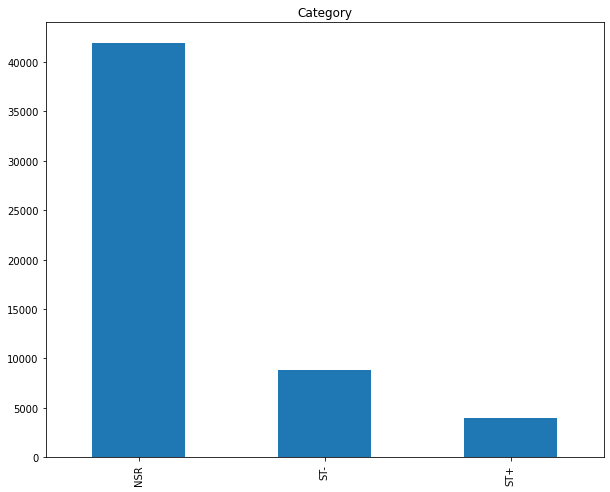

In [6]:
data['label'].value_counts().plot(kind='bar', title='Category', figsize=(10,8))
plt.show()

In [7]:
data.corr()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,mfw_5,...,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16
dw_1,1.000000,0.231317,0.109459,0.074913,0.064543,0.101660,-0.029506,0.023452,-0.001861,0.003290,...,-0.062028,-0.061241,-0.032516,-0.026775,-0.017739,-0.046809,-0.035437,-0.049050,-0.071846,-0.053104
dw_2,0.231317,1.000000,0.839064,0.449006,0.157026,0.490259,-0.520594,-0.307376,-0.002765,0.011760,...,-0.133566,0.150743,0.235204,0.167194,0.046752,0.030436,0.119758,0.004610,-0.117053,-0.076826
dw_3,0.109459,0.839064,1.000000,0.626999,0.236381,0.373744,-0.580056,-0.413234,-0.000351,0.005808,...,-0.207216,0.129536,0.268782,0.117633,-0.049634,0.054751,0.045877,-0.023444,-0.131465,-0.047859
dw_4,0.074913,0.449006,0.626999,1.000000,0.896524,0.070236,-0.268424,-0.208628,0.000763,0.001641,...,-0.143689,0.054827,0.109764,0.050373,-0.044638,0.044048,0.026303,-0.031429,-0.089388,-0.036217
dw_5,0.064543,0.157026,0.236381,0.896524,1.000000,-0.079160,-0.026334,-0.035523,0.000409,-0.000153,...,-0.061473,0.009140,0.005657,0.023553,-0.012439,0.016599,0.014533,-0.033413,-0.041393,-0.021446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfr_12,-0.046809,0.030436,0.054751,0.044048,0.016599,-0.081643,0.054039,0.087235,-0.001785,0.005388,...,-0.130493,-0.207093,-0.090454,0.024675,0.059365,1.000000,0.008142,-0.011310,-0.326522,-0.216222
cfr_13,-0.035437,0.119758,0.045877,0.026303,0.014533,0.076890,-0.003660,0.006739,0.002726,-0.000638,...,0.133437,0.032750,-0.215151,-0.269635,-0.033375,0.008142,1.000000,0.199386,0.109416,-0.168514
cfr_14,-0.049050,0.004610,-0.023444,-0.031429,-0.033413,0.021208,0.025601,0.029224,0.003070,-0.002968,...,0.098660,0.217327,0.047811,-0.175074,-0.289421,-0.011310,0.199386,1.000000,0.171805,-0.139323
cfr_15,-0.071846,-0.117053,-0.131465,-0.089388,-0.041393,-0.006682,0.103513,0.057917,0.004848,-0.008763,...,0.266212,0.164693,-0.079613,-0.147027,-0.089111,-0.326522,0.109416,0.171805,1.000000,0.253573


In [8]:
y = data['label'].values
X = data.loc[:, ~data.columns.isin(["id", "label"])].copy()
patient_ids = data["id"].values

In [9]:
label_encoder = LabelEncoder().fit(y)
y = label_encoder.transform(y)

## Feature selection

### exclude features with corr > 0.95

In [10]:
correlated_features = set()
correlation_matrix = X.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.95:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [11]:
print(correlated_features)

{'fft_229', 'fft_208', 'fft_228', 'mfw_10', 'fft_250', 'fft_164', 'fft_183', 'fft_201', 'mfw_8', 'fft_161', 'fft_134', 'fft_220', 'fft_203', 'fft_192', 'fft_170', 'fft_232', 'fft_211', 'fft_238', 'fft_244', 'fft_217', 'fft_159', 'fft_182', 'fft_140', 'fft_178', 'fft_216', 'fft_241', 'fft_231', 'fft_251', 'fft_196', 'fft_233', 'fft_167', 'fft_222', 'fft_175', 'mfw_6', 'fft_197', 'fft_172', 'fft_194', 'fft_180', 'fft_239', 'fft_190', 'fft_153', 'fft_256', 'fft_142', 'fft_202', 'fft_176', 'fft_221', 'fft_189', 'fft_226', 'fft_141', 'fft_157', 'mfw_11', 'fft_187', 'fft_235', 'fft_245', 'fft_151', 'mfw_15', 'fft_132', 'mfw_5', 'fft_144', 'fft_163', 'fft_133', 'fft_160', 'fft_195', 'fft_199', 'fft_165', 'fft_234', 'mfw_16', 'fft_145', 'fft_207', 'fft_252', 'fft_174', 'fft_218', 'fft_138', 'fft_191', 'fft_219', 'fft_148', 'mfw_12', 'fft_131', 'fft_230', 'fft_168', 'fft_169', 'fft_247', 'fft_213', 'fft_166', 'fft_173', 'fft_209', 'fft_253', 'fft_158', 'fft_152', 'fft_171', 'mfw_14', 'fft_223',

### Random forest embeded for features selection

In [12]:
cols_no_corr = [col for col in X.columns if col not in correlated_features]

In [13]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE), threshold='1.25*median')
embeded_rf_selector.fit(X[cols_no_corr], y)

SelectFromModel(estimator=RandomForestClassifier(n_jobs=4, random_state=101),
                threshold='1.25*median')

In [14]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X[cols_no_corr].loc[:,embeded_rf_support].columns.tolist()

print('\n'.join(embeded_rf_feature), '\nselected features:', len(embeded_rf_feature))

dw_1
dw_2
dw_3
dw_4
dw_5
mfw_1
mfw_2
mfw_3
mfw_4
fft_1
fft_2
fft_3
fft_4
fft_5
fft_6
fft_7
fft_8
fft_9
fft_10
fft_11
fft_12
fft_13
fft_14
fft_15
fft_16
fft_17
fft_18
fft_19
fft_20
fft_21
fft_22
fft_23
fft_24
fft_25
fft_26
fft_27
fft_28
fft_29
fft_30
fft_31
fft_32
fft_33
fft_34
fft_35
fft_36
fft_37
fft_38
ar_1
ar_2
ar_3
ar_4
ar_5
ar_6
ar_7
ar_8
ar_9
ar_10
ar_11
ar_12
ar_15
ar_16
var
cfr_1
cfr_2
cfr_3
cfr_4
cfr_5
cfr_6
cfr_7
cfr_8
cfr_9
cfr_10
cfr_11
cfr_12
cfr_13
cfr_14
cfr_15 
selected features: 77


### Visualization best features

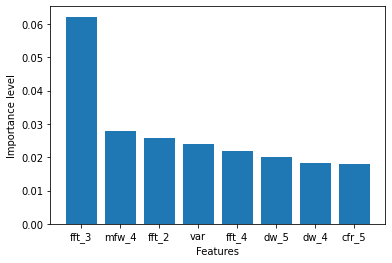

In [15]:
features_dict = dict(zip(cols_no_corr, embeded_rf_selector.estimator_.feature_importances_))
features_dict = dict(sorted(features_dict.items(), key=lambda item: item[1], reverse=True))

best_features = dict()
for index, (key, value) in enumerate(features_dict.items()):
    if index < 8:
        best_features[key] = value

plt.bar(range(len(best_features)), list(best_features.values()), align='center', )
plt.xticks(ticks=range(len(best_features)), labels=best_features.keys())
plt.xlabel('Features')
plt.ylabel('Importance level')
plt.show()

## Filter features

In [16]:
X_fsel = X[embeded_rf_feature]
X_fsel.head()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,fft_1,...,cfr_6,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15
0,39.341333,39.831764,39.826684,11.282887,1.634628,0.913825,-0.771782,-1.359522,-0.634856,0.232364,...,0.019450,0.044698,-0.049375,0.037769,-0.045755,0.051531,-0.078515,0.013704,-0.024545,-0.017430
1,43.320409,45.006516,44.365681,12.474802,1.826689,0.901002,-0.707731,-1.281504,-0.731562,-1.393341,...,0.013422,0.040336,-0.033106,0.009999,-0.014494,0.028882,-0.048873,-0.010926,-0.026088,0.009880
2,41.841597,41.778007,41.593833,11.837152,1.721631,0.911361,-0.728350,-1.293684,-0.729167,-1.923488,...,0.010183,0.036844,-0.049280,0.038759,-0.048515,0.056363,-0.076889,-0.002209,-0.011804,-0.015943
3,43.146961,41.264063,41.075821,11.843259,1.752020,0.906516,-0.728333,-1.275260,-0.678176,-1.560684,...,0.001683,0.048352,-0.065776,0.050750,-0.050526,0.048861,-0.084336,0.026353,-0.035720,-0.018588
4,41.647822,43.131905,43.437246,12.388259,1.809692,0.915806,-0.758906,-1.398698,-0.864005,4.788369,...,0.015460,0.047792,-0.049441,0.035196,-0.047893,0.061977,-0.082722,0.004341,-0.018094,-0.013906


## Random Forest - L1SO

In [17]:
cvds = X_fsel.copy()
cvds["patient_id"] = patient_ids
cvds["label"] = y

patients = np.unique(cvds["patient_id"].values)
patients

array(['e0106', 'e0110', 'e0115', 'e0129', 'e0133', 'e0151', 'e0202',
       'e0203', 'e0204', 'e0205', 'e0206', 'e0207', 'e0208', 'e0210',
       'e0211', 'e0212', 'e0213', 'e0302', 'e0303', 'e0304', 'e0305',
       'e0306', 'e0403', 'e0404', 'e0405', 'e0406', 'e0408', 'e0409',
       'e0410', 'e0411', 'e0413', 'e0415', 'e0417', 'e0418', 'e0515',
       'e0601', 'e0602', 'e0603', 'e0605', 'e0606', 'e0607', 'e0609',
       'e0610', 'e0611', 'e0612', 'e0613', 'e0614', 'e0615', 'e0704',
       'e0801', 'e0808', 'e0817', 'e0818', 'e1301', 'e1302', 'e1304'],
      dtype=object)

In [18]:
classes = np.unique(label_encoder.inverse_transform(y))

In [19]:
result_df = pd.DataFrame()
tot = len(patients)
for i, patient in enumerate(patients):
    start_time = time.time()

    # Train and Test split
    df1 = cvds.loc[cvds["patient_id"] != patient]
    df2 = cvds.loc[cvds["patient_id"] == patient]

    y_train = df1["label"].values
    x_train = df1.loc[:, ~df1.columns.isin(['patient_id', 'label'])]
    y_test = df2["label"].values
    x_test = df2.loc[:, ~df2.columns.isin(['patient_id', 'label'])]

    # Training
    model = RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE).fit(x_train, y_train)

    # Prediction
    y_pred = model.predict(x_test)

    # Decode
    y_test_dec = label_encoder.inverse_transform(y_test)
    y_pred_dec = label_encoder.inverse_transform(y_pred)

    # get metrics
    report = classification_report_imbalanced(y_true=y_test_dec, y_pred=y_pred_dec, labels=label_encoder.classes_, zero_division=1, output_dict=True)
    confusion_matrix = multilabel_confusion_matrix(y_pred=y_pred_dec, y_true=y_test_dec, labels=classes)

    # TOTAL
    tot_accuracy    = accuracy_score(y_true=y_test_dec, y_pred=y_pred_dec)
    tot_precision   = report['avg_pre']
    tot_recall      = report['avg_rec']
    tot_specificity = report['avg_spe']
    tot_f1          = report['avg_f1']

    # NSR
    nsr_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['NSR']
    nsr_precision   = report['NSR']['pre']
    nsr_recall      = report['NSR']['rec']
    nsr_specificity = report['NSR']['spe']
    nsr_f1          = report['NSR']['f1']

    # ST+
    st1_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['ST+']
    st1_precision   = report['ST+']['pre']
    st1_recall      = report['ST+']['rec']
    st1_specificity = report['ST+']['spe']
    st1_f1          = report['ST+']['f1']

    # ST-
    st0_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['ST+']
    st0_precision   = report['ST-']['pre']
    st0_recall      = report['ST-']['rec']
    st0_specificity = report['ST-']['spe']
    st0_f1          = report['ST-']['f1']

    # save result in result_df
    result_df = result_df.append({
        "accuracy": tot_accuracy,
        "precision": tot_precision,
        "recall": tot_recall,
        "specificity": tot_specificity,
        "f1": tot_f1,

        "nsr_accuracy": nsr_accuracy,
        "nsr_precision": nsr_precision,
        "nsr_recall": nsr_recall,
        "nsr_specificity": nsr_specificity,
        "nsr_f1": nsr_f1,

        "st+_accuracy": st1_accuracy,
        "st+_precision": st1_precision,
        "st+_recall": st1_recall,
        "st+_specificity": st1_specificity,
        "st+_f1": st1_f1,

        "st-_accuracy": st0_accuracy,
        "st-_precision": st0_precision,
        "st-_recall": st0_recall,
        "st-_specificity": st0_specificity,
        "st-_f1": st0_f1,
    }, ignore_index=True)
    end_time = time.time()

    elapsed_seconds = end_time - start_time
    # Log result
    print("#---------------------#")
    print(i+1, "of", len(patients), "-", elapsed_seconds, "s")
    print("Tot: Accuracy", tot_accuracy, "Precision", tot_precision, "Recall", tot_recall, "Specificity", tot_specificity, "F1", tot_f1)
    print("NSR: Accuracy", nsr_accuracy, "Precision", nsr_precision, "Recall", nsr_recall, "Specificity", nsr_specificity, "F1", nsr_f1)
    print("ST+: Accuracy", st1_accuracy, "Precision", st1_precision, "Recall", st1_recall, "Specificity", st1_specificity, "F1", st1_f1)
    print("ST-: Accuracy", st0_accuracy, "precision", st0_precision, "Recall", st0_recall, "Specificity", st0_specificity, "F1", st0_f1)
    print("#---------------------#")

c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
1 of 56 - 15.644505023956299 s
Tot: Accuracy 0.8238557558945908 Precision 0.8549256433965171 Recall 0.8238557558945908 Specificity 0.18395674410540916 F1 0.7456678741348414
NSR: Accuracy 0.8238557558945908 Precision 0.8236111111111111 Recall 1.0 Specificity 0.0078125 F1 0.9032749428789032
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0078125 Specificity 1.0 F1 0.015503875968992248
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
2 of 56 - 15.12110161781311 s
Tot: Accuracy 0.8025387870239774 Precision 0.8415297176539395 Recall 0.8025387870239774 Specificity 0.19746121297602257 F1 0.714623739932149
NSR: Accuracy 0.8025387870239774 Precision 0.8025387870239774 Recall 1.0 Specificity 0.0 F1 0.890453834115806
ST+: Accuracy 0.8025387870239774 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.8025387870239774 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
3 of 56 - 14.541061878204346 s
Tot: Accuracy 0.9181338028169014 Precision 0.8445213128994229 Recall 0.9181338028169014 Specificity 0.08090834277696832 F1 0.8797904452876045
NSR: Accuracy 0.9181338028169014 Precision 0.918942731277533 Recall 0.9990421455938697 Specificity 0.0 F1 0.9573198715006884
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 0.0 Specificity 0.9990421455938697 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
4 of 56 - 15.908161640167236 s
Tot: Accuracy 0.8653846153846154 Precision 0.8835059171597633 Recall 0.8653846153846154 Specificity 0.1346153846153846 F1 0.802934179222839
NSR: Accuracy 0.8653846153846154 Precision 0.8653846153846154 Recall 1.0 Specificity 0.0 F1 0.9278350515463918
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
5 of 56 - 15.819299936294556 s
Tot: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 0.0 F1 1.0
NSR: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 0.0 F1 1.0
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
6 of 56 - 15.411123991012573 s
Tot: Accuracy 0.98046875 Precision 1.0 Recall 0.98046875 Specificity 0.0 F1 0.9901380670611438
NSR: Accuracy 0.98046875 Precision 1.0 Recall 0.98046875 Specificity 0.0 F1 0.9901380670611439
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 1.0 Specificity 0.98046875 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
7 of 56 - 15.282224655151367 s
Tot: Accuracy 0.7168494516450648 Precision 0.7972642073778663 Recall 0.7168494516450648 Specificity 0.2936035100274091 F1 0.6016341939537868
NSR: Accuracy 0.7168494516450648 Precision 0.716 Recall 1.0 Specificity 0.010452961672473868 F1 0.8344988344988344
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.010452961672473868 Specificity 1.0 F1 0.020689655172413796
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
8 of 56 - 14.874956369400024 s
Tot: Accuracy 0.7671232876712328 Precision 0.7624175628878778 Recall 0.7671232876712328 Specificity 0.3690996379786762 F1 0.7048939428852938
NSR: Accuracy 0.7671232876712328 Precision 0.7683557394002068 Recall 0.9815059445178336 Specificity 0.15471698113207547 F1 0.8619489559164732
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.7454545454545455 Recall 0.15471698113207547 Specificity 0.9815059445178336 F1 0.25625
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
9 of 56 - 15.256050109863281 s
Tot: Accuracy 0.8343399482312338 Precision 0.9854945158756651 Recall 0.8343399482312338 Specificity 0.7863088352996458 F1 0.8990099743927864
NSR: Accuracy 0.8343399482312338 Precision 0.9968717413972888 Recall 0.8349344978165939 Specificity 0.7857142857142857 F1 0.908745247148289
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.055 Recall 0.7857142857142857 Specificity 0.8349344978165939 F1 0.10280373831775699
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
10 of 56 - 15.271358728408813 s
Tot: Accuracy 0.6512013256006628 Precision 0.7728618408633977 Recall 0.6512013256006628 Specificity 0.3487986743993372 F1 0.5136419888832122
NSR: Accuracy 0.6512013256006628 Precision 0.6512013256006628 Recall 1.0 Specificity 0.0 F1 0.7887606623181134
ST+: Accuracy 0.6512013256006628 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.6512013256006628 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
11 of 56 - 15.979685544967651 s
Tot: Accuracy 0.7874659400544959 Precision 0.7685460769929434 Recall 0.7874659400544959 Specificity 0.34995147961594436 F1 0.7333478175101956
NSR: Accuracy 0.7874659400544959 Precision 0.7942307692307692 Recall 0.9763593380614657 Specificity 0.1607843137254902 F1 0.8759278897136796
ST+: Accuracy 0.9990917347865577 Precision 0.0 Recall 1.0 Specificity 0.9990917347865577 F1 0.0
ST-: Accuracy 0.9990917347865577 precision 0.6833333333333333 Recall 0.1607843137254902 Specificity 0.9775413711583925 F1 0.26031746031746034
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
12 of 56 - 15.840009927749634 s
Tot: Accuracy 0.7572413793103449 Precision 0.8161731272294886 Recall 0.7572413793103449 Specificity 0.24275862068965517 F1 0.6526303253396849
NSR: Accuracy 0.7572413793103449 Precision 0.7572413793103449 Recall 1.0 Specificity 0.0 F1 0.8618524332810047
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
13 of 56 - 15.801248550415039 s
Tot: Accuracy 0.9048697621744054 Precision 0.9139195243231596 Recall 0.9048697621744054 Specificity 0.09513023782559456 F1 0.8596800713167062
NSR: Accuracy 0.9048697621744054 Precision 0.9048697621744054 Recall 1.0 Specificity 0.0 F1 0.9500594530321046
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
14 of 56 - 15.333001852035522 s
Tot: Accuracy 0.8102272727272727 Precision 0.8462409607438016 Recall 0.8102272727272727 Specificity 0.18977272727272726 F1 0.725288192661074
NSR: Accuracy 0.8102272727272727 Precision 0.8102272727272727 Recall 1.0 Specificity 0.0 F1 0.8951663527934715
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
15 of 56 - 15.05160903930664 s
Tot: Accuracy 0.8112211221122112 Precision 0.6707966935175541 Recall 0.8112211221122112 Specificity 0.1783118891599305 F1 0.7343561469849609
NSR: Accuracy 0.8112211221122112 Precision 0.818242343541944 Recall 0.9895330112721417 Specificity 0.0 F1 0.8957725947521866
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 0.0 Specificity 0.9895330112721417 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
16 of 56 - 14.614653825759888 s
Tot: Accuracy 0.9470319634703196 Precision 0.949837576364129 Recall 0.9470319634703196 Specificity 0.052968036529680365 F1 0.9212684297548982
NSR: Accuracy 0.9470319634703196 Precision 0.9470319634703196 Recall 1.0 Specificity 0.0 F1 0.9727954971857411
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
17 of 56 - 15.266600131988525 s
Tot: Accuracy 0.7451154529307282 Precision 0.7641580722194424 Recall 0.7451154529307282 Specificity 0.3848461076258533 F1 0.673501378704966
NSR: Accuracy 0.7451154529307282 Precision 0.7411214953271028 Recall 0.987546699875467 Specificity 0.14241486068111456 F1 0.8467698878804057
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.8214285714285714 Recall 0.14241486068111456 Specificity 0.987546699875467 F1 0.2427440633245383
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
18 of 56 - 15.372062921524048 s
Tot: Accuracy 0.9688398849472675 Precision 0.969810837717367 Recall 0.9688398849472675 Specificity 0.0311601150527325 F1 0.953506407342794
NSR: Accuracy 0.9688398849472675 Precision 0.9688398849472675 Recall 1.0 Specificity 0.0 F1 0.9841733625517409
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
19 of 56 - 15.449205875396729 s
Tot: Accuracy 0.8592178770949721 Precision 0.8790374832246185 Recall 0.8592178770949721 Specificity 0.14078212290502792 F1 0.7941569080360981
NSR: Accuracy 0.8592178770949721 Precision 0.8592178770949721 Recall 1.0 Specificity 0.0 F1 0.9242788461538461
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
20 of 56 - 14.895531177520752 s
Tot: Accuracy 0.9874776386404294 Precision 0.9786292727027911 Recall 0.9874776386404294 Specificity 0.010714043095556194 F1 0.9830335448571691
NSR: Accuracy 0.9874776386404294 Precision 0.989247311827957 Recall 0.9981916817359855 Specificity 0.0 F1 0.9936993699369937
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 0.0 Specificity 0.9981916817359855 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
21 of 56 - 14.945334672927856 s
Tot: Accuracy 0.8151260504201681 Precision 0.8493763821318001 Recall 0.8151260504201681 Specificity 0.1961099046360117 F1 0.7341799519498441
NSR: Accuracy 0.8151260504201681 Precision 0.8147368421052632 Recall 1.0 Specificity 0.011235955056179775 F1 0.8979118329466358
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.011235955056179775 Specificity 1.0 F1 0.02222222222222222
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
22 of 56 - 15.43479299545288 s
Tot: Accuracy 0.6716791979949874 Precision 0.779473747024202 Recall 0.6716791979949874 Specificity 0.3283208020050125 F1 0.5397601950904247
NSR: Accuracy 0.6716791979949874 Precision 0.6716791979949874 Recall 1.0 Specificity 0.0 F1 0.8035982008995503
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
23 of 56 - 15.624282598495483 s
Tot: Accuracy 0.35224839400428265 Precision 0.6381188761274414 Recall 0.35224839400428265 Specificity 0.6673695277920946 F1 0.21910527430512716
NSR: Accuracy 0.3533190578158458 Precision 0.33666666666666667 Recall 0.9774193548387097 Specificity 0.04326923076923077 F1 0.5008264462809918
ST+: Accuracy 0.35224839400428265 Precision 0.7878787878787878 Recall 0.041666666666666664 Specificity 0.9774193548387097 F1 0.0791476407914764
ST-: Accuracy 0.35224839400428265 precision 0.0 Recall 1.0 Specificity 0.9989293361884368 F1 0.0
#---------------------#
#---------------------#
24 of 56 - 15.439424276351929 s
Tot: Accuracy 0.8445078459343794 Precision 0.8686856559103462 Recall 0.8445078459343794 Specificity 0.15549215406562053 F1 0.7733157692082794
NSR: Accuracy 0.8445078459343794 Precision 0.8445078459343794 Recall 1.0 Specificity 0.0 F1 0.9156999226604794
ST+: Accuracy 0.9087018544935807 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST

c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
25 of 56 - 14.891219139099121 s
Tot: Accuracy 0.6922390722569135 Precision 0.772540614687321 Recall 0.6922390722569135 Specificity 0.35878326432550944 F1 0.5828218209436096
NSR: Accuracy 0.6922390722569135 Precision 0.6875567665758402 Recall 0.9986807387862797 Specificity 0.05234159779614325 F1 0.8144163528778914
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.95 Recall 0.05234159779614325 Specificity 0.9986807387862797 F1 0.09921671018276762
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
26 of 56 - 15.221680402755737 s
Tot: Accuracy 0.7317880794701986 Precision 0.8040222945861232 Recall 0.7317880794701986 Specificity 0.2671081677704194 F1 0.6193846842169687
NSR: Accuracy 0.7317880794701986 Precision 0.7325966850828729 Recall 0.9984939759036144 Specificity 0.0 F1 0.8451242829827916
ST+: Accuracy 0.9988962472406181 Precision 0.0 Recall 1.0 Specificity 0.9988962472406181 F1 0.0
ST-: Accuracy 0.9988962472406181 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
27 of 56 - 16.14433240890503 s
Tot: Accuracy 0.7202643171806168 Precision 0.838467766314422 Recall 0.7202643171806168 Specificity 0.348010330101095 F1 0.7700482926953851
NSR: Accuracy 0.7202643171806168 Precision 0.9127906976744186 Recall 0.7639902676399026 Specificity 0.3023255813953488 F1 0.8317880794701985
ST+: Accuracy 0.9812775330396476 Precision 0.0 Recall 1.0 Specificity 0.9812775330396476 F1 0.0
ST-: Accuracy 0.9812775330396476 precision 0.12807881773399016 Recall 0.3023255813953488 Specificity 0.7846715328467153 F1 0.17993079584775087
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
28 of 56 - 15.733976125717163 s
Tot: Accuracy 0.08992248062015504 Precision 0.9536145372375482 Recall 0.08992248062015504 Specificity 0.9533121055324957 F1 0.0848572068032254
NSR: Accuracy 0.08992248062015504 Precision 0.05020242914979757 Recall 0.9841269841269841 Specificity 0.044009779951100246 F1 0.09553158705701077
ST+: Accuracy 0.9992248062015504 Precision 0.0 Recall 1.0 Specificity 0.9992248062015504 F1 0.0
ST-: Accuracy 0.9992248062015504 precision 1.0 Recall 0.044009779951100246 Specificity 1.0 F1 0.08430913348946135
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
29 of 56 - 15.094456911087036 s
Tot: Accuracy 0.14361001317523056 Precision 0.8770138227089593 Recall 0.14361001317523056 Specificity 0.8563899868247694 F1 0.03606795261774225
NSR: Accuracy 0.14361001317523056 Precision 0.14361001317523056 Recall 1.0 Specificity 0.0 F1 0.2511520737327189
ST+: Accuracy 0.14361001317523056 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.14361001317523056 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
30 of 56 - 14.909886837005615 s
Tot: Accuracy 0.9201596806387226 Precision 0.930480062943321 Recall 0.9201596806387226 Specificity 0.08800819413803972 F1 0.8861860262833667
NSR: Accuracy 0.9211576846307385 Precision 0.9247743229689067 Recall 0.9956803455723542 Specificity 0.013157894736842105 F1 0.9589183567342694
ST+: Accuracy 0.9950099800399201 Precision 0.0 Recall 1.0 Specificity 0.9950099800399201 F1 0.0
ST-: Accuracy 0.9950099800399201 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
31 of 56 - 15.11601996421814 s
Tot: Accuracy 0.9001218026796589 Precision 0.8799015741253822 Recall 0.9001218026796589 Specificity 0.3330271781963858 F1 0.8836683396976681
NSR: Accuracy 0.9013398294762485 Precision 0.9193341869398207 Recall 0.9755434782608695 Specificity 0.25882352941176473 F1 0.9466051417270929
ST+: Accuracy 0.9987819732034104 Precision 0.0 Recall 1.0 Specificity 0.9987819732034104 F1 0.0
ST-: Accuracy 0.9987819732034104 precision 0.5384615384615384 Recall 0.24705882352941178 Specificity 0.9755434782608695 F1 0.33870967741935487
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
32 of 56 - 15.685681581497192 s
Tot: Accuracy 0.5080576759966073 Precision 0.7568166541325861 Recall 0.5080576759966073 Specificity 0.5442299057027391 F1 0.3697649685723149
NSR: Accuracy 0.5080576759966073 Precision 0.4943330427201395 Recall 1.0 Specificity 0.05228758169934641 F1 0.661610268378063
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.05228758169934641 Specificity 1.0 F1 0.09937888198757763
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
33 of 56 - 14.969739198684692 s
Tot: Accuracy 0.847732181425486 Precision 0.8709176699989272 Recall 0.847732181425486 Specificity 0.15226781857451405 F1 0.7778723114190609
NSR: Accuracy 0.847732181425486 Precision 0.847732181425486 Recall 1.0 Specificity 0.0 F1 0.9175920514319112
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
34 of 56 - 14.574262380599976 s
Tot: Accuracy 0.7035775127768313 Precision 0.9329906356464491 Recall 0.7035775127768313 Specificity 0.8431134183726986 F1 0.7792732412057995
NSR: Accuracy 0.7035775127768313 Precision 0.9857697283311773 Recall 0.6933575978161965 Specificity 0.8533333333333334 F1 0.8141025641025641
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.1596009975062344 Recall 0.8533333333333334 Specificity 0.6933575978161965 F1 0.26890756302521013
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
35 of 56 - 15.210940599441528 s
Tot: Accuracy 0.9442413162705667 Precision 0.9496562367517517 Recall 0.9442413162705667 Specificity 0.05301645338208409 F1 0.9198251092207872
NSR: Accuracy 0.9442413162705667 Precision 0.9468377635197067 Recall 0.997104247104247 Specificity 0.0 F1 0.9713211095439587
ST+: Accuracy 0.9972577696526508 Precision 0.0 Recall 1.0 Specificity 0.9972577696526508 F1 0.0
ST-: Accuracy 0.9972577696526508 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
36 of 56 - 14.68167781829834 s
Tot: Accuracy 0.9832589285714286 Precision 1.0 Recall 0.9832589285714286 Specificity 0.0 F1 0.9915588069780529
NSR: Accuracy 0.9832589285714286 Precision 1.0 Recall 0.9832589285714286 Specificity 0.0 F1 0.9915588069780529
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 1.0 Specificity 0.9832589285714286 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
37 of 56 - 14.742220401763916 s
Tot: Accuracy 0.8727758007117438 Precision 0.8647044984216465 Recall 0.8727758007117438 Specificity 0.3852817687334136 F1 0.8681930961738816
NSR: Accuracy 0.8736654804270463 Precision 0.9209756097560976 Recall 0.9393034825870646 Specificity 0.31932773109243695 F1 0.9300492610837439
ST+: Accuracy 0.99644128113879 Precision 0.0 Recall 1.0 Specificity 0.99644128113879 F1 0.0
ST-: Accuracy 0.99644128113879 precision 0.3894736842105263 Recall 0.31092436974789917 Specificity 0.9422885572139303 F1 0.3457943925233645
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
38 of 56 - 14.70706582069397 s
Tot: Accuracy 0.04625 Precision 0.9558917396745933 Recall 0.04625 Specificity 0.953810615989515 F1 0.004093899521531101
NSR: Accuracy 0.0475 Precision 0.04630788485607009 Recall 1.0 Specificity 0.001310615989515072 F1 0.08851674641148326
ST+: Accuracy 0.04625 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.04625 precision 0.0 Recall 1.0 Specificity 0.99875 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
39 of 56 - 14.383845329284668 s
Tot: Accuracy 0.7662116040955631 Precision 0.7340958073595585 Recall 0.7662116040955631 Specificity 0.31824902220531354 F1 0.7003924068591927
NSR: Accuracy 0.7670648464163823 Precision 0.776386404293381 Recall 0.9741863075196409 Specificity 0.1103202846975089 F1 0.8641114982578397
ST+: Accuracy 0.9965870307167235 Precision 0.0 Recall 1.0 Specificity 0.9965870307167235 F1 0.0
ST-: Accuracy 0.9965870307167235 precision 0.6 Recall 0.10676156583629894 Specificity 0.9775533108866442 F1 0.1812688821752266
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
40 of 56 - 14.751986026763916 s
Tot: Accuracy 0.8565573770491803 Precision 0.8637271210259369 Recall 0.8565573770491803 Specificity 0.4034338394637753 F1 0.8228216435301093
NSR: Accuracy 0.8565573770491803 Precision 0.8535791757049892 Recall 0.9936868686868687 Specificity 0.266304347826087 F1 0.9183197199533255
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.9074074074074074 Recall 0.266304347826087 Specificity 0.9936868686868687 F1 0.411764705882353
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
41 of 56 - 14.746127843856812 s
Tot: Accuracy 0.37151106833493747 Precision 0.770348067729773 Recall 0.37151106833493747 Specificity 0.6435718879244895 F1 0.212656206225948
NSR: Accuracy 0.37151106833493747 Precision 0.3654033041788144 Recall 1.0 Specificity 0.015082956259426848 F1 0.5352313167259787
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.015082956259426848 Specificity 1.0 F1 0.02971768202080238
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
42 of 56 - 14.503953456878662 s
Tot: Accuracy 0.9311440677966102 Precision 0.9219160135743213 Recall 0.9311440677966102 Specificity 0.31346172011626433 F1 0.925996092943467
NSR: Accuracy 0.9311440677966102 Precision 0.9557522123893806 Recall 0.9718785151856018 Specificity 0.2727272727272727 F1 0.9637479085331847
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.375 Recall 0.2727272727272727 Specificity 0.9718785151856018 F1 0.3157894736842105
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
43 of 56 - 14.93068265914917 s
Tot: Accuracy 0.8574969021065675 Precision 0.8778040350157927 Recall 0.8574969021065675 Specificity 0.14250309789343246 F1 0.7917116160877182
NSR: Accuracy 0.8574969021065675 Precision 0.8574969021065675 Recall 1.0 Specificity 0.0 F1 0.923282188125417
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
44 of 56 - 14.87990689277649 s
Tot: Accuracy 0.9983193277310924 Precision 1.0 Recall 0.9983193277310924 Specificity 0.0 F1 0.9991589571068125
NSR: Accuracy 0.9983193277310924 Precision 1.0 Recall 0.9983193277310924 Specificity 0.0 F1 0.9991589571068125
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 1.0 Specificity 0.9983193277310924 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
45 of 56 - 14.665076971054077 s
Tot: Accuracy 0.6154929577464788 Precision 0.7658950864276569 Recall 0.6154929577464788 Specificity 0.40069142125480156 F1 0.4735722028133658
NSR: Accuracy 0.6211267605633802 Precision 0.6178977272727273 Recall 1.0 Specificity 0.02181818181818182 F1 0.7638279192273925
ST+: Accuracy 0.6154929577464788 Precision 1.0 Recall 0.007272727272727273 Specificity 1.0 F1 0.014440433212996389
ST-: Accuracy 0.6154929577464788 precision 0.0 Recall 1.0 Specificity 0.9943661971830986 F1 0.0
#---------------------#
#---------------------#
46 of 56 - 14.585005044937134 s
Tot: Accuracy 0.7534076827757125 Precision 0.814215453689756 Recall 0.7534076827757125 Specificity 0.24659231722428748 F1 0.6474514079542518
NSR: Accuracy 0.7534076827757125 Precision 0.7534076827757125 Recall 1.0 Specificity 0.0 F1 0.8593639575971731
ST+: Accuracy 0.9801734820322181 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.9801734820322181 precision 1.0 Reca

c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
47 of 56 - 14.545941352844238 s
Tot: Accuracy 0.43870402802101577 Precision 0.5436487734892359 Recall 0.43870402802101577 Specificity 0.5791891002604513 F1 0.34624103716485866
NSR: Accuracy 0.4413309982486865 Precision 0.4201762977473066 Recall 0.9031578947368422 Specificity 0.11244377811094453 F1 0.573529411764706
ST+: Accuracy 0.9938704028021016 Precision 0.0 Recall 1.0 Specificity 0.9938704028021016 F1 0.0
ST-: Accuracy 0.9938704028021016 precision 0.631578947368421 Recall 0.10794602698650675 Specificity 0.911578947368421 F1 0.18437900128040974
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
48 of 56 - 14.650428295135498 s
Tot: Accuracy 0.9767123287671233 Precision 0.9779299847792999 Recall 0.9767123287671233 Specificity 0.12191611937588795 F1 0.9773170818350431
NSR: Accuracy 0.9767123287671233 Precision 0.9888888888888889 Recall 0.9875173370319001 Specificity 0.1111111111111111 F1 0.9882026370575989
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.1 Recall 0.1111111111111111 Specificity 0.9875173370319001 F1 0.10526315789473685
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
49 of 56 - 14.253970623016357 s
Tot: Accuracy 0.9959308240081384 Precision 1.0 Recall 0.9959308240081384 Specificity 0.0 F1 0.9979612640163099
NSR: Accuracy 0.9959308240081384 Precision 1.0 Recall 0.9959308240081384 Specificity 0.0 F1 0.9979612640163099
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 1.0 Specificity 0.9959308240081384 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
50 of 56 - 15.065441131591797 s
Tot: Accuracy 0.9886363636363636 Precision 1.0 Recall 0.9886363636363636 Specificity 0.0 F1 0.9942857142857142
NSR: Accuracy 0.9886363636363636 Precision 1.0 Recall 0.9886363636363636 Specificity 0.0 F1 0.9942857142857142
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 1.0 Specificity 0.9886363636363636 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
51 of 56 - 14.46391749382019 s
Tot: Accuracy 0.11806167400881057 Precision 0.8932389477017553 Recall 0.11806167400881057 Specificity 0.8823165531837803 F1 0.026341974152329604
NSR: Accuracy 0.14625550660792952 Precision 0.12192902638762511 Recall 0.9710144927536232 Specificity 0.0320962888665998 F1 0.21665319320937754
ST+: Accuracy 0.12158590308370044 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.12158590308370044 precision 0.0 Recall 1.0 Specificity 0.9682819383259912 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
52 of 56 - 14.61820673942566 s
Tot: Accuracy 0.9567979669631512 Precision 1.0 Recall 0.9567979669631512 Specificity 0.0 F1 0.9779220779220779
NSR: Accuracy 0.9567979669631512 Precision 1.0 Recall 0.9567979669631512 Specificity 0.0 F1 0.977922077922078
ST+: Accuracy 0.9567979669631512 Precision 0.0 Recall 1.0 Specificity 0.9567979669631512 F1 0.0
ST-: Accuracy 0.9567979669631512 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
53 of 56 - 14.563519716262817 s
Tot: Accuracy 0.7913043478260869 Precision 0.8107482134864409 Recall 0.7913043478260869 Specificity 0.48703399977863415 F1 0.7508811714778156
NSR: Accuracy 0.7913043478260869 Precision 0.7816826411075612 Recall 0.9852348993288591 Specificity 0.29310344827586204 F1 0.8717339667458432
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.8854166666666666 Recall 0.29310344827586204 Specificity 0.9852348993288591 F1 0.4404145077720207
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
54 of 56 - 14.428762674331665 s
Tot: Accuracy 0.8703071672354948 Precision 0.8482771030495256 Recall 0.8703071672354948 Specificity 0.21477188414790432 F1 0.8248765778515696
NSR: Accuracy 0.8703071672354948 Precision 0.8736964078794901 Recall 0.9934123847167325 Specificity 0.09166666666666666 F1 0.9297163995067818
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.6875 Recall 0.09166666666666666 Specificity 0.9934123847167325 F1 0.16176470588235292
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
55 of 56 - 14.689488649368286 s
Tot: Accuracy 0.9066193853427896 Precision 0.9153393245365481 Recall 0.9066193853427896 Specificity 0.0933806146572104 F1 0.8622158320618967
NSR: Accuracy 0.9066193853427896 Precision 0.9066193853427896 Recall 1.0 Specificity 0.0 F1 0.9510229386236826
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#
#---------------------#
56 of 56 - 14.807645797729492 s
Tot: Accuracy 0.7754077791718946 Precision 0.8258494448283951 Recall 0.7754077791718946 Specificity 0.2245922208281054 F1 0.6773173251282416
NSR: Accuracy 0.7754077791718946 Precision 0.7754077791718946 Recall 1.0 Specificity 0.0 F1 0.8734982332155478
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
result_df.head(10)

,accuracy,precision,recall,specificity,f1,nsr_accuracy,nsr_precision,nsr_recall,nsr_specificity,nsr_f1,st+_accuracy,st+_precision,st+_recall,st+_specificity,st+_f1,st-_accuracy,st-_precision,st-_recall,st-_specificity,st-_f1
0,0.823856,0.854926,0.823856,0.183957,0.745668,0.823856,0.823611,1.000000,0.007812,0.903275,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,0.007812,1.000000,0.015504
1,0.802539,0.841530,0.802539,0.197461,0.714624,0.802539,0.802539,1.000000,0.000000,0.890454,0.802539,1.0,0.0,1.0,0.0,0.802539,1.000000,1.000000,1.000000,1.000000
2,0.918134,0.844521,0.918134,0.080908,0.879790,0.918134,0.918943,0.999042,0.000000,0.957320,1.000000,1.0,1.0,1.0,1.0,1.000000,0.000000,0.000000,0.999042,0.000000
3,0.865385,0.883506,0.865385,0.134615,0.802934,0.865385,0.865385,1.000000,0.000000,0.927835,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,0.000000,1.000000,0.000000
4,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
5,0.980469,1.000000,0.980469,0.000000,0.990138,0.980469,1.000000,0.980469,0.000000,0.990138,1.000000,1.0,1.0,1.0,1.0,1.000000,0.000000,1.000000,0.980469,0.000000
6,0.716849,0.797264,0.716849,0.293604,0.601634,0.716849,0.716000,1.000000,0.010453,0.834499,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,0.010453,1.000000,0.020690
7,0.767123,0.762418,0.767123,0.369100,0.704894,0.767123,0.768356,0.981506,0.154717,0.861949,1.000000,1.0,1.0,1.0,1.0,1.000000,0.745455,0.154717,0.981506,0.256250
8,0.834340,0.985495,0.834340,0.786309,0.899010,0.834340,0.996872,0.834934,0.785714,0.908745,1.000000,1.0,1.0,1.0,1.0,1.000000,0.055000,0.785714,0.834934,0.102804
9,0.651201,0.772862,0.651201,0.348799,0.513642,0.651201,0.651201,1.000000,0.000000,0.788761,0.651201,1.0,0.0,1.0,0.0,0.651201,1.000000,1.000000,1.000000,1.000000


In [21]:
print("######## Total ########")
print("Accuracy",       result_df["accuracy"].mean())
print("Precision",      result_df["precision"].mean())
print("Recall",         result_df["recall"].mean())
print("Specificity",    result_df["specificity"].mean())
print("F1",             result_df["f1"].mean())

print("######## NSR ########")
print("Accuracy",       result_df["nsr_accuracy"].mean())
print("Precision",      result_df["nsr_precision"].mean())
print("Recall",         result_df["nsr_recall"].mean())
print("Specificity",    result_df["nsr_specificity"].mean())
print("F1",             result_df["nsr_f1"].mean())

print("######## ST+ ########")
print("Accuracy",       result_df["st+_accuracy"].mean())
print("Precision",      result_df["st+_precision"].mean())
print("Recall",         result_df["st+_recall"].mean())
print("Specificity",    result_df["st+_specificity"].mean())
print("F1",             result_df["st+_f1"].mean())

print("######## ST- ########")
print("Accuracy",       result_df["st-_accuracy"].mean())
print("Precision",      result_df["st-_precision"].mean())
print("Recall",         result_df["st-_recall"].mean())
print("Specificity",    result_df["st-_specificity"].mean())
print("F1",             result_df["st-_f1"].mean())

result_df.to_csv('result/multi_10beats_l1so.csv')

######## Total ########
Accuracy 0.7624069146513521
Precision 0.8640245801476171
Recall 0.7624069146513521
Specificity 0.29690184136443415
F1 0.7095035922246785
######## NSR ########
Accuracy 0.7631700257634947
Precision 0.7761055680530669
Recall 0.9781127616496398
Specificity 0.08107130483064896
F1 0.833952920382857
######## ST+ ########
Accuracy 0.9202685614811651
Precision 0.7997835497835498
Recall 0.840159632034632
Specificity 0.9980474300111398
F1 0.6445283584643656
######## ST- ########
Accuracy 0.9202685614811651
Precision 0.6546024019566292
Recall 0.328573505734347
Specificity 0.9801900211739973
F1 0.16369893368555324
